# TensorFlow Tutorial - Transfer Learning for Multi-Class Car Image Classification

### Step-by-step guide to using the pre-trained ResNet model for image classification of Stanford Cars dataset

Notebook From: https://github.com/kennethleungty/TensorFlow-Transfer-Learning-Image-Classification

Tutorial From: https://towardsdatascience.com/practical-guide-to-transfer-learning-in-tensorflow-for-multiclass-image-classification-d35fab7b28c0

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/)

## (1) Initial Setup
- Highly recommended to run this notebook in Google Colab
- All the essential Python libraries we need for this project are already pre-installed in the default Google Colab environment

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import keras_cv

2023-04-12 16:58:23.248111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 16:58:23.715701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/stepheny/miniconda3/envs/tf/lib/:/home/stepheny/miniconda3/envs/tf/lib/python3.9/site-packages/nvidia/cudnn/lib
2023-04-12 16:58:23.717430: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/step

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


/home/stepheny/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check TensorFlow version
tf. __version__

'2.11.0'

In [3]:
# Check if GPU acceleration is available
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


___
## (2) Import Data
- For this project, we will be working with the Stanford Cars dataset (https://ai.stanford.edu/~jkrause/cars/car_dataset.html)
-  The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. 
- Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.
- While there are various sources where the Cars image dataset can be downloaded from, we will use the `tfds` module to load the images. `tfds` stands for Tensorflow Datasets, and it is a Tensorflow component that defines a collection of datasets ready-to-use with TensorFlow

#### Load and split the raw image data
- We load the Stanford cars dataset (named as `cars196` in `tfds`) as a `tf.data.Dataset` object, and the raw dataset has two sets: train and test
- For our project, we want to split the dataset into three sets: train set, validation set, and test set. 
- The train/val split is set as 90:10 ratio, and we also ensure the images are shuffled
- The original test set is very large (8000+ images), so we only take 10% of it to form our own test set
- We can use percentages (%) to slice the datasets, so that there is no need for us to input the exact index for splitting
- Note that when we set the parameter `with_info=True`, we will also obtain the dataset documentation along with the images. 
- This dataset documentation (which we save as `ds_info`) contains a host of information, but perhaps the most important one is the label name (i.e. car make and model) for each image class
- The output will be captured as a tuple: (image datasets, dataset information) when we set `as_supervised=True`

In [4]:
(train_raw, val_raw, test_raw), ds_info = tfds.load('cars196', # name of cars dataset in tfds
                                           split=['train[:90%]', # Perform train/val split (90/10)
                                                  'train[90%:]',
                                                  'test[:10%]'], # Use only 10% of test set for testing
                                           shuffle_files=True, # Shuffle the order of images
                                           as_supervised=True, # Returns (image, label)
                                           with_info=True # To retrieve dataset info and label names
                                           )

💬 **Checkpoint**
- Earlier we made use of the Tensorflow component called Tensorflow Datasets (`tfds`) to load a pre-saved dataset
- If we have custom datasets (e.g., CSV files) that we want to load into `tfds`, refer to the following guides:
    - https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset

#### Display several examples of the image dataset (from the train set) using the in-built `tfds.show_examples` function

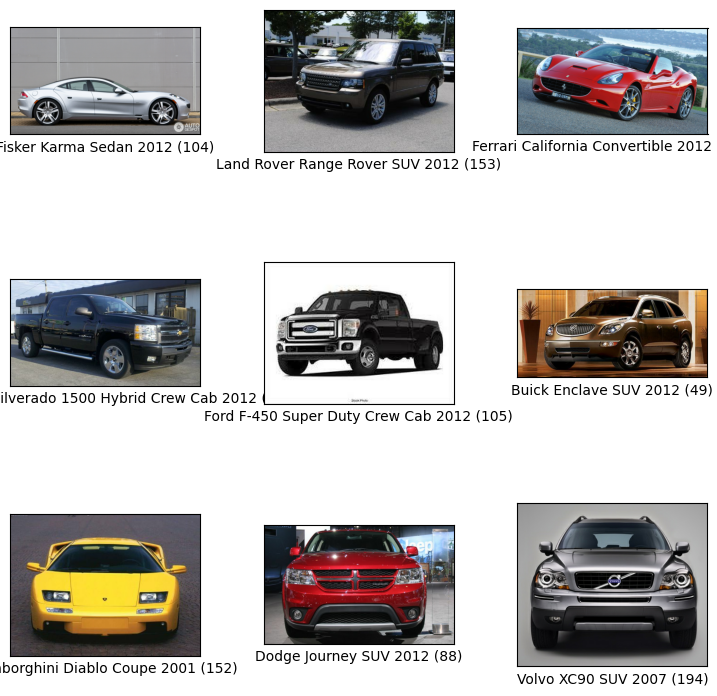

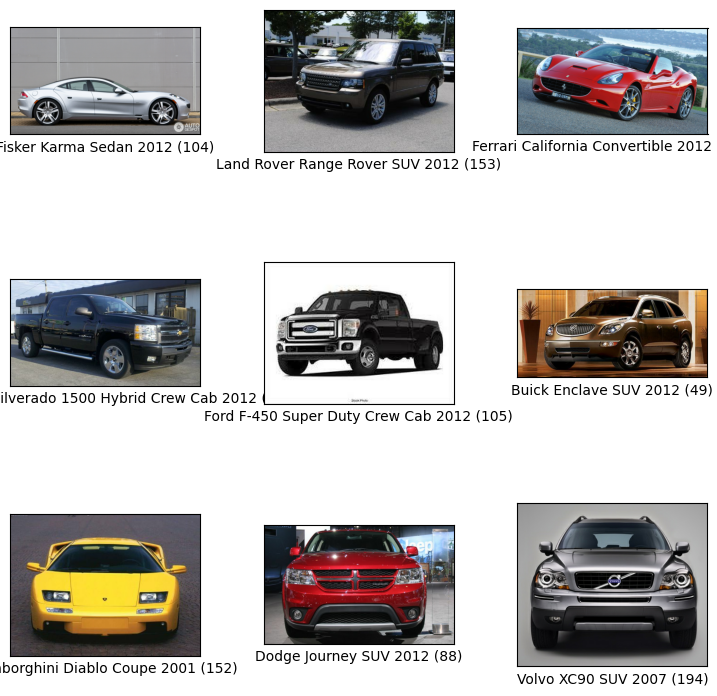

In [5]:
# Display examples
tfds.show_examples(train_raw, ds_info)

___
## (3) Understanding the dataset
#### Retrieve relevant counts to better understand the dataset we will be working on

In [6]:
# Get number of classes
num_classes = ds_info.features['label'].num_classes
print('Number of car classes:', num_classes)

Number of car classes: 196


In [7]:
# Get number of train, val, and test examples
num_train_examples = tf.data.experimental.cardinality(train_raw).numpy()
num_val_examples = tf.data.experimental.cardinality(val_raw).numpy()
num_test_examples = tf.data.experimental.cardinality(test_raw).numpy()

print('Number of training samples:', num_train_examples)
print('Number of validation samples:', num_val_examples)
print('Number of test samples:', num_test_examples)

Number of training samples: 7330
Number of validation samples: 814
Number of test samples: 804


In [8]:
# Get the distribution of class labels (in integers) in the train and validation sets
def get_value_counts(ds):
    label_list = []
    for images, labels in ds: 
        label_list.append(labels.numpy())
        label_counts = pd.Series(label_list).value_counts(sort=True)
    print(label_counts)

___
#### Viewing a single image
- We create a custom function to display the image as well as the label
- From the section above, we can see that the default class label for each image is in the form of integer
- We can instantiate a function (which we call `get_label_name`) to retrieve the label name for each class integer

In [9]:
# Function within the dataset documentation object that converts class integer to label name
get_label_name = ds_info.features['label'].int2str

In [10]:
# Build the custom function to display image and label name
def view_single_image(ds):
    image, label = next(iter(ds))
    print('Image shape: ', image.shape)
    plt.imshow(image)
    _ = plt.title(get_label_name(label))

Image shape:  (576, 1024, 3)


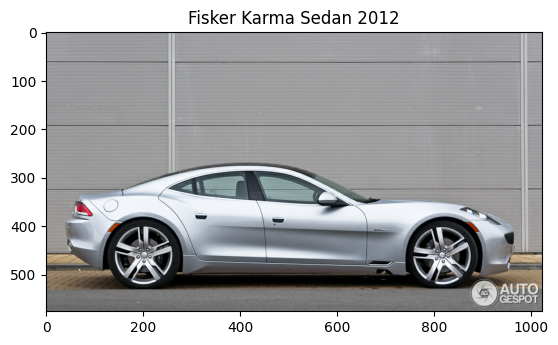

In [11]:
view_single_image(train_raw)

___
## (4) Data Preparation

### (i) Image Resizing
- Because the raw images come in different sizes, we want to resize them to the same size before parsing them into the neural network later
- More specifically, we want both the length and width to be 224 pixels

In [12]:
IMG_SIZE = 224

train_ds = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
val_ds = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
test_ds = test_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


___
### (ii) Label One-hot Encoding
- There are 196 classes (i.e. types of cars) in the dataset that we are using for multi-class image classification
- As such, we proceed to one-hot encode the labels so that we get a label vector of length 196

In [13]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [14]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

#### Let's have a look at what our dataset object looks like currently

In [15]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(196,), dtype=tf.float32, name=None))>

From the printout, we can see that each dataset object (i.e., `train_ds`, `val_ds`, and `test_ds`) has two components each:
- Images of shape (224,224,3) 
- Label vector of shape (196,)

The values in each component has also been casted to a float data type, which is what we want for the deep learning model later. Another point to keep in mind is that these objects are **generators**, meaning that they only return one set of image and label when we iterate over it one value at a time.

___
### (iii) Image (Data) Augmentation
- Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.
- The purpose is to reduce model overfitting by exposing our model to variations and small transformations in the original data. It is useful especially when we do not have a large dataset.
- Note that the image augmentation needs to be realistic. For example, flipping car images upside down may not be the best choice here since we expect most cars to be photographed with the wheels on the ground (barring severe accidents)
- To perform data augmentation, we use the Keras preprocessing layers API. Each type of image augmentation that we want to introduce is defined as a layer within a Keras Sequential class.
- We will only perform a random horizontal flip for the images for the sake of simplicity, though do note that there is a wide range of different augmentations available to us: https://keras.io/api/layers/preprocessing_layers/image_augmentation/

In [16]:
data_augmentation = keras.Sequential(
                [layers.RandomFlip('horizontal'), 
                #  layers.RandomRotation(factor=(-0.025, 0.025)),
                #  layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
                #  layers.RandomContrast(factor=0.1),
                 ])

#### View effects of augmentation

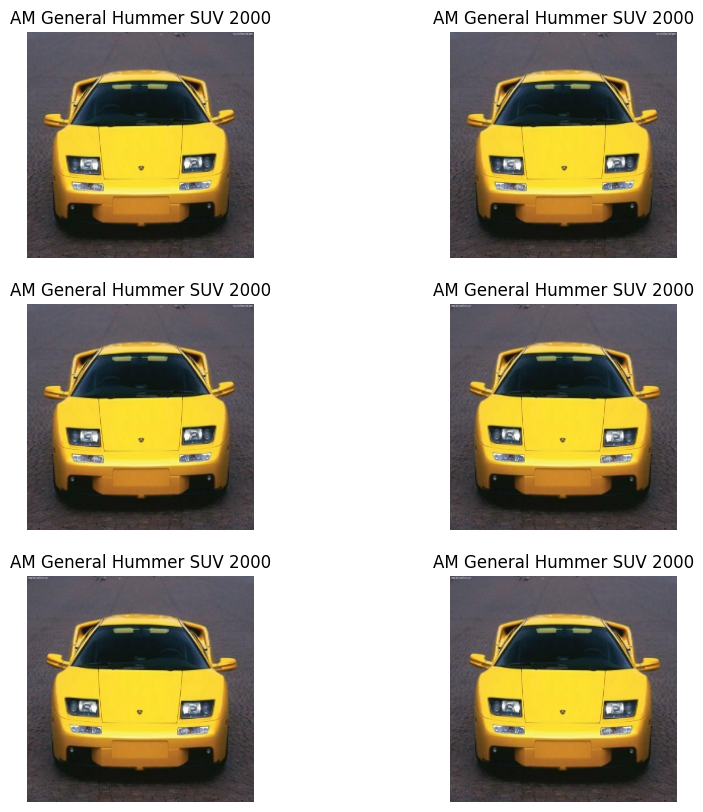

In [17]:
for image, label in train_ds.take(1): # Iterate and retrieve one set of image and label from the train_ds generator object
    plt.figure(figsize=(10, 10))
    for i in range(6):  # Display six augmented images in a grid of 3 x 2
        ax = plt.subplot(3, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype('uint8')) # Retrieve raw values from augmented image
        plt.title(get_label_name(int(label[0]))) # Using get_label_name function to retrieve label name
        plt.axis("off")

### (iv) Batching and Prefetching
- We can batch the data and use prefetching to optimize loading speed
- A batch size of 64 is a good value to start with
- The number of elements to prefetch can be automatically determined by making use of `tf.data.AUTOTUNE`, which prompt the runtime to tune the value dynamically for us.

In [18]:
BATCH_SIZE = 64

In [19]:
# Batch the data and use prefetching to optimize loading speed
train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

- After batching and prefetching, note that the dataset object has been transformed such that the earlier functions to view images will no longer work
- Caching (with `.cache()`) is another way to speed up the process, where we store dataset either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch. However, note that this can cause RAM limit issues in the free version of Google Colab, thus caching has been excluded in this step.

___
## (5) Model Setup
- With the data prepared, it is time to define the model we want to use for the multi-class classification task
- For this task, we will make use of transfer learning so that we do not need to train a deep learning model from scratch (which is tedious and requires plenty of data)
- Keras comes with a host of pre-trained models that we can leverage for transfer learning: https://keras.io/api/applications/
- The image below is just a subset of all the pre-trained models available:

![models](https://raw.githubusercontent.com/kennethleungty/TensorFlow-Transfer-Learning-Image-Classification/main/images/keras_applications_models_subset.png)

- We will be using ResNet50V2 given that it offers a good balance of accuracy, size, and speed
- More information about ResNet can be found here: https://keras.io/api/applications/resnet/

### (i) Setup base model
- Instantiate a ResNet50V2 object from `keras.applications`
- Set `include_top=False` because we want to remove the top layers of the pre-trained model (that was trained to classify ImageNet) and introduce our own final layers for our specific car image classification task
- Keep the weights as `imagenet`, because we want to keep the ResNet weights that were trained on the ImageNet dataset
- This process is known as transfer learning, because we use the pre-trained ImageNet weights

https://github.com/qubvel/classification_models

In [20]:
from classification_models.keras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

In [21]:
base_model = ResNet18(
                    include_top=False, # Exclude ImageNet classifier at the top
                    weights='imagenet',
                    input_shape=(IMG_SIZE, IMG_SIZE, 3),
                    )

### (ii) Freeze pre-trained weights of the base model
- When a trainable weight becomes non-trainable, its value is no longer updated during training.

In [22]:
# Freeze the base_model
base_model.trainable = False

### (iii) Modify inputs
- We pre-process the inputs (i.e., images) so that they are compatible with what the pre-trained ResNet50v2 architecture expects

In [23]:
# Setup inputs with shape of our images
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Apply augmentation
x = data_augmentation(inputs)

In [24]:
# Apply the specific pre-processing function for ResNet v2
x = preprocess_input(x)

In [25]:
# Keep the base model batch normalization layers in inference mode (instead of training mode)
x = base_model(x, training=False)

- Although the base model becomes trainable, it is still running in inference mode since we passed `training=False` when calling it when we built the model.
- This means that the batch normalization layers inside will not update their batch statistics (i.e., mean and variance)
- If they did, they would wreak havoc on the representations learned by the model so far because the training done would have been undone.

### (iv) Rebuild top layers
- Given that we have removed the top ImageNet classifier layer of ResNet50V2, we can now build a custom top layer that is specific to our image classification task i.e., classify an image based on the 196 different car types.

In [26]:
# Rebuild top layers
x = layers.GlobalAveragePooling2D()(x) # Average pooling operation
x = layers.BatchNormalization()(x) # Introduce batch norm
x = layers.Dropout(0.2)(x)  # Regularize with dropout

# Flattening to final layer - Dense classifier with 196 units (multi-class classification)
outputs = layers.Dense(num_classes, activation='linear')(x)

# Instantiate final Keras model with updated inputs and outputs
model = keras.Model(inputs, outputs)

💬 **Checkpoint**
- Recap what is the purpose of the average pooling layer i.e., `layers.GlobalAveragePooling2D`

#### Display model summary

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 7, 7, 512)         11186889  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0   

___
## (6) Model Training

#### Compile model
- Utilize the commonly used Adam optimizer (leave the learning rate as default)
- Since it is a multi-class classification, we will use categorical cross entropy and categorical accuracy as our loss and performance metric respectively

In [28]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SquaredHinge(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

#### Fit model
- Ensure that the Google Colab runtime using GPU hardware accelerator
- Fit the model over the training dataset for 15 epochs
- Store the training output as a variable called `history`

In [29]:
EPOCHS = 15

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1)

Epoch 1/15
114/114 [==============================] - 11s 69ms/step - loss: 1.0312 - categorical_accuracy: 0.0053 - val_loss: 0.0358 - val_categorical_accuracy: 0.0117
Epoch 2/15
114/114 [==============================] - 8s 67ms/step - loss: 0.0625 - categorical_accuracy: 0.0260 - val_loss: 0.0371 - val_categorical_accuracy: 0.0716
Epoch 3/15
114/114 [==============================] - 8s 67ms/step - loss: 0.0413 - categorical_accuracy: 0.0862 - val_loss: 0.0335 - val_categorical_accuracy: 0.1263
Epoch 4/15
114/114 [==============================] - 8s 67ms/step - loss: 0.0344 - categorical_accuracy: 0.1657 - val_loss: 0.0310 - val_categorical_accuracy: 0.1732
Epoch 5/15
114/114 [==============================] - 8s 67ms/step - loss: 0.0303 - categorical_accuracy: 0.2315 - val_loss: 0.0292 - val_categorical_accuracy: 0.2253
Epoch 6/15
114/114 [==============================] - 8s 67ms/step - loss: 0.0266 - categorical_accuracy: 0.3047 - val_loss: 0.0281 - val_categorical_accuracy: 0.25

#### Plot the accuracy of training and validation sets over epochs

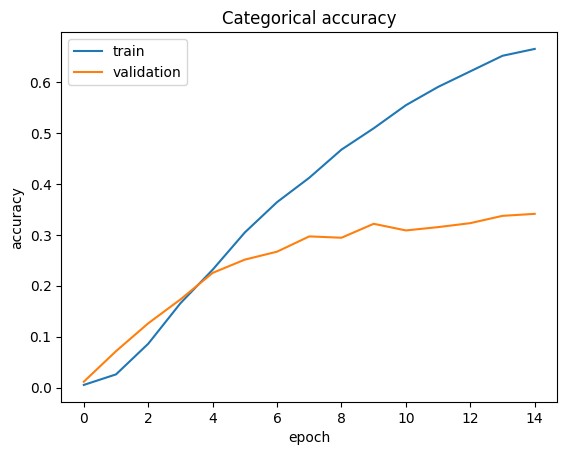

In [30]:
def plot_metric_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_metric_hist(history)

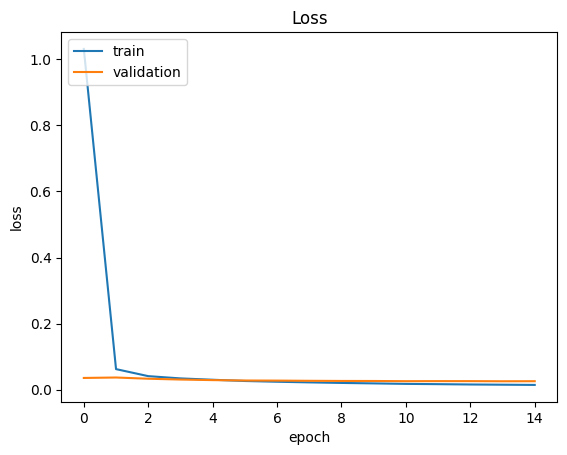

In [31]:
def plot_loss_hist(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_loss_hist(history)